# Data Cleaning
In this notebook I clean and prepare the Yelp review data for modeling. In addition, I do some data exploration to understand the dataset.

## Setup

Import Python libraries.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import spacy
import sys

from google.colab import drive
from importlib.machinery import SourceFileLoader

%matplotlib inline

Mount Google drive

In [0]:
ROOT = '/content/drive'
PROJECT = 'My Drive/Thinkful/Final_Capstone_Project/'
PROJECT_PATH = os.path.join(ROOT, PROJECT)

In [3]:
# drive.mount(ROOT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Load custom constants and methods.

In [4]:
con = SourceFileLoader('constants', os.path.join(PROJECT_PATH, 'utilities/constants.py')).load_module()
met = SourceFileLoader('methods', os.path.join(PROJECT_PATH, 'utilities/methods.py')).load_module()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Load Data
Read in businesses data into a Pandas **`DataFrame`**.

In [0]:
df_businesses = pd.read_csv(os.path.join(PROJECT_PATH, 'data/businesses.csv'))

In [6]:
df_businesses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
id              1000 non-null object
name            1000 non-null object
is_closed       1000 non-null bool
review_count    1000 non-null int64
rating          1000 non-null float64
distance        1000 non-null float64
dtypes: bool(1), float64(2), int64(1), object(2)
memory usage: 40.2+ KB


In [7]:
num_unique_businesses = len(df_businesses['id'].unique())
print(f"There are {num_unique_businesses} unique businesses.")

There are 1000 unique businesses.


In [8]:
num_closed_businesses = df_businesses['is_closed'].sum()
print(f"The dataset contains {num_closed_businesses} closed businesses.")

The dataset contains 0 closed businesses.


Read in reviews data into a Pandas **`DataFrame`**.

In [0]:
df_reviews = pd.read_csv(os.path.join(PROJECT_PATH, 'data/full_reviews.csv'))

In [10]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5374 entries, 0 to 5373
Data columns (total 2 columns):
rating    5374 non-null int64
text      5374 non-null object
dtypes: int64(1), object(1)
memory usage: 84.1+ KB


In [11]:
print(f'The dataset consists of {len(df_reviews)} reviews.')

The dataset consists of 5374 reviews.


## Data Exploration
### Ratings
Let's look at the distribution of restaurant ratings.

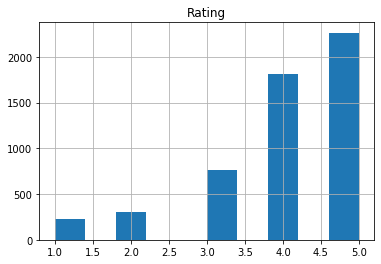

In [12]:
df_reviews['rating'].hist()
plt.title('Rating')
plt.show()

I will use the ratings as the labels when I perform the modeling. Since I am only interested in positive and negative reviews, I will divide the ratings into two groups. For starters, I will say positive reviews are those above 3, while negative reviews are those 3 and below. I will label the negative reviews with 1 and the positive reviews with 0.

In [0]:
ratings = df_reviews['rating'].values
negative_ratings = ratings < 4
df_reviews['labels'] = negative_ratings.astype(int)

In [14]:
df_reviews.loc[:5, ['rating', 'labels']]

,rating,labels
0,5,0
1,3,1
2,4,0
3,4,0
4,4,0
5,2,1


In [15]:
print(f'There are {df_reviews["labels"].sum()} negative reviews.')
print(f'There are {len(df_reviews) - df_reviews["labels"].sum()} positive reviews.')

There are 1299 negative reviews.
There are 4075 positive reviews.


In [16]:
num_postive_reviews = len(df_reviews) - df_reviews["labels"].sum()
positive_review_ratio = num_postive_reviews / len(df_reviews)
print(f'The fraction of positive reviews in this dataset is {positive_review_ratio:0.3f}')

The fraction of positive reviews in this dataset is 0.758


This dataset is clearning highly skewed. I will address this issue during the modeling phase.

### Reviews
Now let's investigate review lengths. First, we can look at review lengths in terms of number of characters.

In [0]:
df_reviews['character_count'] = df_reviews['text'].apply(lambda x: len(''.join(x.split())))

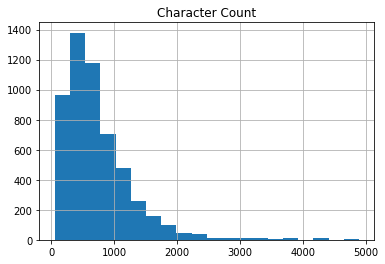

In [18]:
df_reviews['character_count'].hist(bins=20)
plt.title('Character Count')
plt.show()

Now, let's look at the distribution of word counts for each review.

In [0]:
df_reviews['word_count'] = df_reviews['text'].apply(lambda x: len(x.split()))

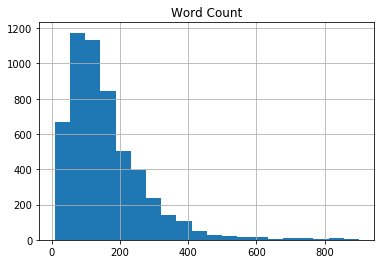

In [20]:
df_reviews['word_count'].hist(bins=20)
plt.title('Word Count')
plt.show()

We can compare rating, character count, and review count together using the `describe()` method in Pandas.

In [21]:
df_reviews.loc[:, ['rating', 'character_count', 'word_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
rating,5374.0,4.038333,1.081983,1.0,4.0,4.0,5.0,5.0
character_count,5374.0,733.942501,543.348104,58.0,373.0,604.0,937.0,4887.0
word_count,5374.0,157.988463,114.587534,9.0,80.0,132.0,204.0,901.0


## Data Cleaning
I will perform pre-processing of the text data in the reviews using [Spacy](https://spacy.io/).

In [0]:
# Load Spacy's toolset
nlp = spacy.load("en_core_web_sm")

### Tokenization
The first step is to split the words in the reviews into tokens. This is called tokenization. Spacy will not only tokenize each word, it will also tokenize the punctuation.

In [23]:
df_reviews.loc[:5, 'text']

0    A friend and I randomly picked this place out ...
1    Came in on a Thursday afternoon for lunch and ...
2    Great food. Weak service, even at the bar. <br...
3    Great spot downtown SJ, with great food. Came ...
4    I came for the drinks and they did not disappo...
5    I've been here for HH on a number of occasions...
Name: text, dtype: object

In [0]:
df_reviews['text_split'] = df_reviews['text'].apply(lambda x: [y.text for y in nlp(x)])

In [25]:
df_reviews.loc[:5, 'text_split']

0    [A, friend, and, I, randomly, picked, this, pl...
1    [Came, in, on, a, Thursday, afternoon, for, lu...
2    [Great, food, ., Weak, service, ,, even, at, t...
3    [Great, spot, downtown, SJ, ,, with, great, fo...
4    [I, came, for, the, drinks, and, they, did, no...
5    [I, 've, been, here, for, HH, on, a, number, o...
Name: text_split, dtype: object

### Lemmatization
We can also convert the text data into tokenized lemma's. A lemma is the most basic form for a word. For example, the word _picked_ will be changed to _pick_, converting the past tense of the word to its present tense.

In [0]:
df_reviews['lemma'] = df_reviews['text'].apply(lambda x: [y.lemma_ for y in nlp(x)])

In [27]:
df_reviews.loc[:5, 'lemma']

0    [a, friend, and, -PRON-, randomly, pick, this,...
1    [come, in, on, a, Thursday, afternoon, for, lu...
2    [great, food, ., weak, service, ,, even, at, t...
3    [great, spot, downtown, SJ, ,, with, great, fo...
4    [-PRON-, come, for, the, drink, and, -PRON-, d...
5    [-PRON-, have, be, here, for, HH, on, a, numbe...
Name: lemma, dtype: object

### Stop Words
Stop words are insignicant words with little real meanings related to the overall context of a document. Spacy contains a large list of stop words. These can be used to tag the words in the corpus of review documents with boolean values to flag whether they are stop words or not.

In [0]:
df_reviews['stop'] = df_reviews['text'].apply(lambda x: [y.is_stop for y in nlp(x)])

In [29]:
df_reviews.loc[:5, 'stop']

0    [True, False, True, True, False, False, True, ...
1    [False, True, True, True, False, False, True, ...
2    [False, False, False, False, False, False, Tru...
3    [False, False, False, False, False, True, Fals...
4    [True, False, True, True, False, True, True, T...
5    [True, True, True, True, True, False, True, Tr...
Name: stop, dtype: object

Let's compare the relationship between the total word counts in each document with the number of stop words in each document.

In [0]:
df_reviews['word_count'] = df_reviews['text_split'].apply(lambda x: len(x))

In [0]:
df_reviews['stop_count'] = df_reviews['stop'].apply(lambda x: np.sum(x))

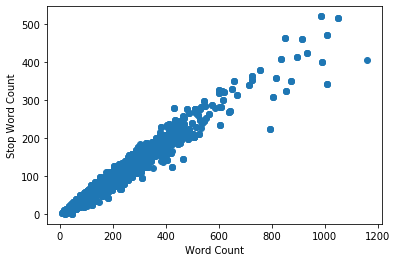

In [32]:
plt.scatter(df_reviews['word_count'], df_reviews['stop_count'])
plt.xlabel('Word Count')
plt.ylabel('Stop Word Count')
plt.show()

In [0]:
df_reviews['stop_word_fraction'] = df_reviews['stop_count'] / df_reviews['word_count']

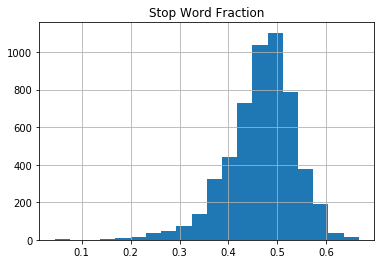

In [34]:
df_reviews['stop_word_fraction'].hist(bins=20)
plt.title('Stop Word Fraction')
plt.show()

The distribution in stop word counts is roughly normal, with most reviews consisting of a little under 50% of stop words.

I will now remove the stop words from each review.

In [0]:
def filter_stop_words(lemma, stop):
  clean_words = [not x for x in stop]
  clean_array = np.array(clean_words)
  lemma_array = np.array(lemma)
  return list(lemma_array[clean_array])

In [0]:
df_reviews['stop_free'] = df_reviews.apply(lambda x: filter_stop_words(x['lemma'], x['stop']), axis=1)

In [37]:
df_reviews.loc[:5, 'stop_free']

0    [friend, randomly, pick, place, handful, place...
1    [come, Thursday, afternoon, lunch, group, 4, s...
2    [great, food, ., weak, service, ,, bar, ., <, ...
3    [great, spot, downtown, SJ, ,, great, food, .,...
4    [come, drink, disappoint, ., highly, recommend...
5    [HH, number, occasion, remember, food, lot, ta...
Name: stop_free, dtype: object

### Non-alpha Words
Now, I will filter out tokens that are not alpha, string, words. This will remove numeric values as well as punctuation.

In [0]:
df_reviews['clean_text'] = df_reviews['stop_free'].apply(lambda x: [y for y in x if y.isalpha()])

In [39]:
df_reviews.loc[:5, 'clean_text']

0    [friend, randomly, pick, place, handful, place...
1    [come, Thursday, afternoon, lunch, group, seat...
2    [great, food, weak, service, bar, small, place...
3    [great, spot, downtown, SJ, great, food, come,...
4    [come, drink, disappoint, highly, recommend, c...
5    [HH, number, occasion, remember, food, lot, ta...
Name: clean_text, dtype: object

In [0]:
df_reviews['clean_word_count'] = df_reviews['clean_text'].apply(lambda x: len(x))

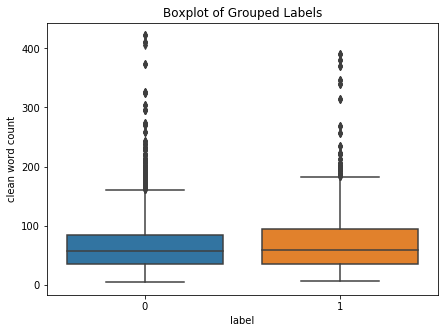

In [41]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(x='labels', y='clean_word_count', data=df_reviews, ax=ax)
ax.set_xlabel('label')
ax.set_ylabel('clean word count')
ax.set_title('Boxplot of Grouped Labels')
plt.show()

## Vocabulary Size
Now that the dataset is clean, I can calculate the vocabulary size. The vocabulary is the set of all unique words in the corpus.

In [42]:
cleaned_corpus = []
for document in df_reviews['clean_text'].values:
  cleaned_corpus += document
vocab = np.unique(cleaned_corpus)
vocab_size = len(vocab)
print(f'The corpus size is {len(cleaned_corpus)}.')
print(f'The vocabulary size is {vocab_size}.')

The corpus size is 368444.
The vocabulary size is 10386.


### Tokens to Sequences
Lastly, I will merge the tokens into sequences of strings. The models I will use prefers this kind of data structure.

In [0]:
df_reviews['text_seq'] = df_reviews['clean_text'].apply(lambda x: (' '.join(x)))

In [44]:
df_reviews.loc[:5, 'text_seq']

0    friend randomly pick place handful place visit...
1    come Thursday afternoon lunch group seat immed...
2    great food weak service bar small place know n...
3    great spot downtown SJ great food come dinner ...
4    come drink disappoint highly recommend come vi...
5    HH number occasion remember food lot tasty yea...
Name: text_seq, dtype: object

The final, cleaned dataset consists of the following columns:

In [45]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5374 entries, 0 to 5373
Data columns (total 14 columns):
rating                5374 non-null int64
text                  5374 non-null object
labels                5374 non-null int64
character_count       5374 non-null int64
word_count            5374 non-null int64
text_split            5374 non-null object
lemma                 5374 non-null object
stop                  5374 non-null object
stop_count            5374 non-null int64
stop_word_fraction    5374 non-null float64
stop_free             5374 non-null object
clean_text            5374 non-null object
clean_word_count      5374 non-null int64
text_seq              5374 non-null object
dtypes: float64(1), int64(6), object(7)
memory usage: 587.9+ KB


## Save Cleaned Data
The dataset has now been cleaned and the text has been preprocessed for modeling. I will save it to a csv file, which I can load during modeling.

In [0]:
df_reviews.loc[:, ['clean_text', 'text_seq', 'labels']].to_csv(os.path.join(PROJECT_PATH, 'data/cleaned_full.csv'), index=False)

## Mediocre Reviews
Drop 3 star reviews and see how model performance and topic analysis change.

In [0]:
df_extremes = df_reviews[df_reviews['rating'] != 3].copy()

In [0]:
df_extremes.loc[:, ['clean_text', 'text_seq', 'labels']].to_csv(os.path.join(PROJECT_PATH, 'data/cleaned_extremes.csv'), index=False)

In [49]:
cleaned_corpus = []
for document in df_extremes['clean_text'].values:
  cleaned_corpus += document
vocab = np.unique(cleaned_corpus)
vocab_size = len(vocab)
print(f'The corpus size is {len(cleaned_corpus)}.')
print(f'The vocabulary size is {vocab_size}.')

The corpus size is 308939.
The vocabulary size is 9566.
